In [7]:
import yfinance as yf
import vectorbt as vbt
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Downloading Data from Yfinance

In [2]:

# Define the cryptocurrency tickers (assuming Yahoo Finance has these tickers)
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'SOL-USD']
period = '2y'  # Two years

# Download the historical data
data = yf.download(tickers, period=period)['Close']

# Display the first few rows of the data
print(data.head())

[*********************100%%**********************]  5 of 5 completed

Ticker       ADA-USD     BNB-USD       BTC-USD      ETH-USD    SOL-USD
Date                                                                  
2022-06-20  0.492261  216.934265  20599.537109  1127.642456  35.417114
2022-06-21  0.479204  219.498627  20710.597656  1124.824585  36.121159
2022-06-22  0.458568  214.261917  19987.029297  1051.421875  34.121635
2022-06-23  0.480292  228.953751  21085.876953  1143.386719  38.175232
2022-06-24  0.499224  240.238312  21231.656250  1226.844727  42.212048


Simple Backtest using Moving Average

In [6]:
# Define moving average windows
short_window = 20
long_window = 50

# Calculate moving averages
sma_short = data.rolling(window=short_window).mean()
sma_long = data.rolling(window=long_window).mean()

# Define the entry and exit signals
entries = sma_short > sma_long
exits = sma_short < sma_long

# Run the backtest for each cryptocurrency
portfolios = {}
initial_cash = 10000
for ticker in tickers:
    portfolios[ticker] = vbt.Portfolio.from_signals(
        close=data[ticker],
        entries=entries[ticker],
        exits=exits[ticker],
        init_cash=initial_cash,
        fees=0.001  # Example trading fee
    )

# Display the backtest results for each cryptocurrency
for ticker, portfolio in portfolios.items():
    print(f"Backtest results for {ticker}:")
    print(portfolio.stats())
    portfolio.value().vbt.plot(title=f'Portfolio Value for {ticker}').show()
    portfolio.plot(subplots=['orders', 'trade_pnl']).show()



Backtest results for BTC-USD:
Start                         2022-06-20 00:00:00
End                           2024-06-20 00:00:00
Period                          732 days 00:00:00
Start Value                               10000.0
End Value                             12310.59246
Total Return [%]                        23.105925
Benchmark Return [%]                    221.13927
Max Gross Exposure [%]                      100.0
Total Fees Paid                         142.28962
Max Drawdown [%]                        36.222934
Max Drawdown Duration           477 days 00:00:00
Total Trades                                    9
Total Closed Trades                             8
Total Open Trades                               1
Open Trade PnL                        -592.146767
Win Rate [%]                                 37.5
Best Trade [%]                          42.972309
Worst Trade [%]                        -19.099978
Avg Winning Trade [%]                   27.238014
Avg Losing Trade [%]

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

LTSM Time Series Foresacting Model

[*********************100%%**********************]  1 of 1 completed


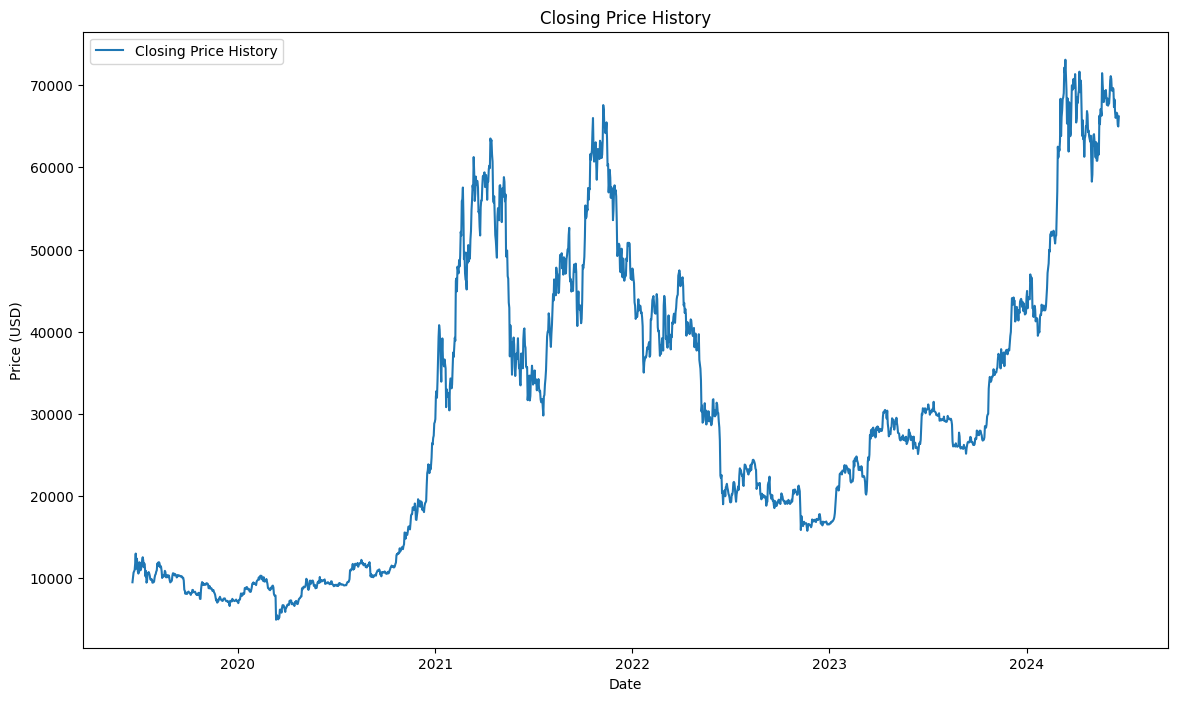

In [8]:
# Download historical data
ticker = 'BTC-USD'
data = yf.download(ticker, period='5y')

# Prepare the dataset
data = data[['Close']]
data = data.dropna()

# Plot the closing price history
plt.figure(figsize=(14, 8))
plt.plot(data, label='Closing Price History')
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [10]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # 60 days
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data to be 3-dimensional for the LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


2024-06-20 15:00:34.627847: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 15:00:34.635467: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 15:00:34.743759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 15:00:36.777815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/20


/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0420 - val_loss: 0.0062
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0024 - val_l

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


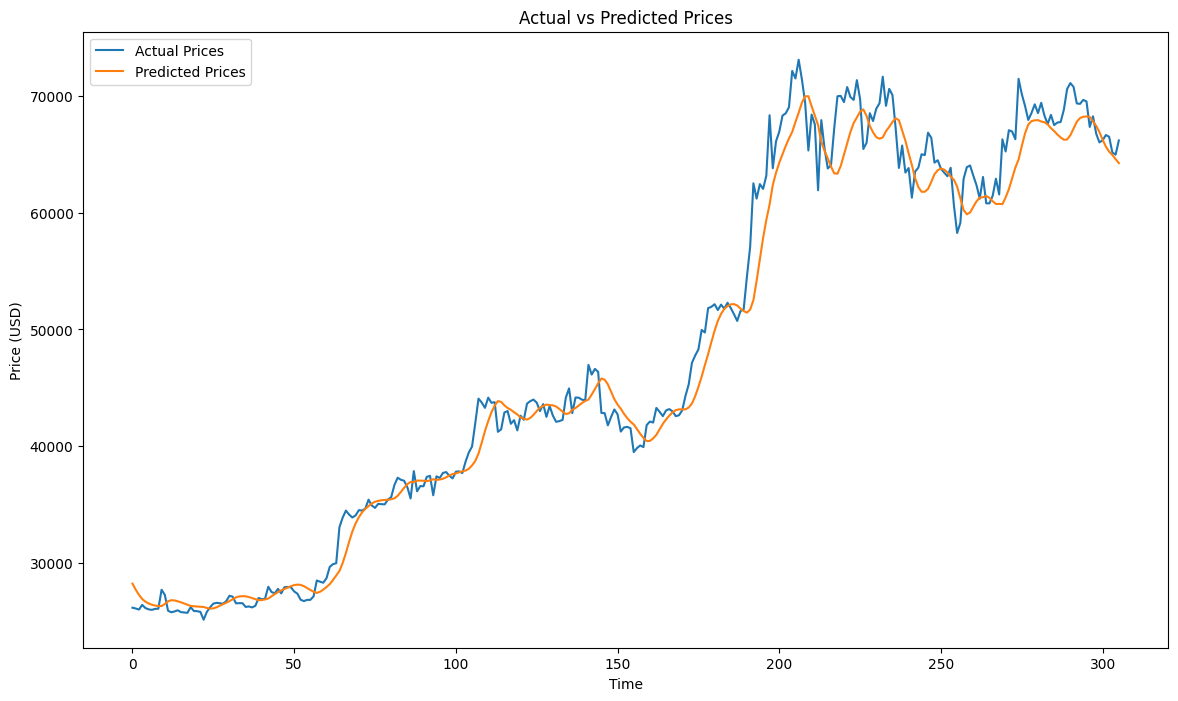

In [12]:
# Predict the test data
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Inverse transform the actual prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [13]:
model.save('crypto_lstm_model.h5')


1. Walk-Forward Analysis

In [14]:
import numpy as np
import vectorbt as vbt

def walk_forward_analysis(data, model, sequence_length, train_size=0.8, step_size=0.1):
    segments = int((1 - train_size) / step_size)
    results = []
    
    for i in range(segments):
        split_index = int(len(data) * (train_size + i * step_size))
        train_data = data[:split_index]
        test_data = data[split_index:split_index + int(len(data) * step_size)]
        
        # Create sequences
        X_train, y_train = create_sequences(train_data, sequence_length)
        X_test, y_test = create_sequences(test_data, sequence_length)
        
        # Reshape the data
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32)
        
        # Predict the test data
        predictions = model.predict(X_test)
        results.append(predictions)
    
    return np.concatenate(results)

# Example usage
predicted_prices = walk_forward_analysis(scaled_data, model, sequence_length)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0018
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0018
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0016
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0018
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0014
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0017
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0013
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0016
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0014
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2. Monte Carlo Simulation

In [15]:
def monte_carlo_simulation(prices, n_simulations=1000, n_days=252):
    log_returns = np.log(1 + prices.pct_change())
    mean = log_returns.mean()
    var = log_returns.var()
    drift = mean - (0.5 * var)
    std = log_returns.std()
    
    simulations = np.zeros((n_days, n_simulations))
    simulations[0] = prices.iloc[-1]
    
    for t in range(1, n_days):
        shocks = drift + std * np.random.normal(size=n_simulations)
        simulations[t] = simulations[t - 1] * np.exp(shocks)
    
    return simulations

# Example usage
simulated_paths = monte_carlo_simulation(data['Close'])


3. Bootstrapping

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import vectorbt as vbt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Download historical data
ticker = 'BTC-USD'
data = yf.download(ticker, period='5y')

# Prepare the dataset
data = data[['Close']]
data = data.dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # 60 days
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Define the perform_backtest function
def perform_backtest(data):
    # Generate trading signals based on LSTM predictions
    sequence_length = 60
    X, _ = create_sequences(scaler.transform(data.values.reshape(-1, 1)), sequence_length)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    
    current_prices = scaler.inverse_transform(X[:, -1, 0].reshape(-1, 1))
    signals = predictions > current_prices
    
    # Create a DataFrame to hold the signals
    signal_df = pd.DataFrame({
        'actual': data.iloc[-len(predictions):].values.flatten(),
        'predicted': predictions.flatten(),
        'signals': signals.flatten()
    }, index=data.index[-len(predictions):])
    
    # Define the entry and exit signals based on predictions
    entries = signal_df['signals']
    exits = ~signal_df['signals']
    
    # Run the backtest
    portfolio = vbt.Portfolio.from_signals(
        close=signal_df['actual'],
        entries=entries,
        exits=exits,
        init_cash=10000,
        fees=0.001  # Example trading fee
    )
    
    return portfolio.stats()

# Bootstrap backtesting
def bootstrap_backtest(data, n_iterations=1000):
    results = []
    for i in range(n_iterations):
        bootstrap_sample = resample(data)
        result = perform_backtest(bootstrap_sample['Close'])
        results.append(result)
    return results

# Example usage
bootstrap_results = bootstrap_backtest(data, n_iterations=10)

# Display results
for i, result in enumerate(bootstrap_results):
    print(f"Bootstrap iteration {i+1}:")
    print(result)



[*********************100%%**********************]  1 of 1 completed

Epoch 1/20



/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0471
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0041
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0031
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0030
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0028
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0027
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0028
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0023
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0024
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0021
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0022
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0022
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0022
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0018
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0019
Epoch 16/20
44/

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 4/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 5/56 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
 1/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Bootstrap iteration 1:
Start                           2020-08-22 00:00:00
End                             2023-03-13 00:00:00
Period                                         1768
Start Value                                 10000.0
End Value                     14876154690173.537109
Total Return [%]                148761546801.735382
Benchmark Return [%]                     107.138292
Max Gross Exposure [%]                        100.0
Total Fees Paid                  2313920125926489.5
Max Drawdown [%]                          99.999967
Max Drawdown Duration                         380.0
Total Trades                                    444
Total Closed Trades                             443
Total Open Trades                                 1
Open Trade PnL                 1583075206107.611328
Win Rate [%]                               52.82167
Best Trade [%]                           902.178029
Worst Trade [%]                          -89.598992
A

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



7. Rolling Window Backtesting

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # 60 days
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Define the rolling window backtest function
def rolling_window_backtest(data, model, window_size, step_size):
    results = []
    
    for i in range(0, len(data) - window_size, step_size):
        train_data = data[i:i + window_size]
        test_data = data[i + window_size:i + window_size + step_size]
        
        # Create sequences
        X_train, y_train = create_sequences(train_data, sequence_length)
        X_test, y_test = create_sequences(test_data, sequence_length)
        
        if X_test.size == 0:  # Skip if test data is too small
            continue
        
        # Reshape the data
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        
        # Predict the test data
        predictions = model.predict(X_test)
        results.append(predictions)
    
    return np.concatenate(results) if results else np.array([])

# Example usage
predicted_prices = rolling_window_backtest(scaled_data, model, window_size=500, step_size=60)

# Rescale the predicted prices back to the original scale
predicted_prices_rescaled = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predicted_prices_rescaled):], data['Close'].values[-len(predicted_prices_rescaled):], label='Actual Prices')
plt.plot(data.index[-len(predicted_prices_rescaled):], predicted_prices_rescaled, label='Predicted Prices')
plt.legend()
plt.show()


Epoch 1/20


/home/moraa/Documents/10_academy/Week-9/Crypto-Trading-Engineering/MLOps/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0441
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0034
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0028
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0030
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0027
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0026
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0024
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0024
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0022
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0024
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0024
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0020
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0021
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0021
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0017
Epoch 16/20
44/

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.